In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datetime import date, datetime, timezone
import os
import warnings

import git
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import yaml

import pop_tools
import esmlab
import esmlab_regrid
print(esmlab_regrid.__version__) # Currently using ~/codes/esmlab_regrid (installed with pip -e from my fork)

from gen_remap_weights_1d import gen_remap_weights_1d
import config
import util

2019.5.2.dev8+g815fd28.d20211008


In [3]:
# script identifier to go in generated file

repo = 'github.com/marbl-ecosys/marbl-forcing'
sha = git.Repo(search_parent_directories=True).head.object.hexsha
script_fname = 'initial_conditions/gen_mom6_omip_IC.ipynb'
id_string = f'{repo}/tree/{sha}/{script_fname}'

In [4]:
# input specifications

tracernames = [ 'TEMP', 'SALT',
    'NO3', 'PO4', 'SiO3', 'O2', 'DIC', 'ALK', 
    'spC', 'spChl', 'spFe', 'spP', 'spCaCO3', 
    'diatC', 'diatChl', 'diatFe', 'diatP', 'diatSi', 
    'diazC', 'diazChl', 'diazFe', 'diazP', 
    'zooC', 
    'DOC', 'DOCr', 'DON', 'DONr', 'DOP', 'DOPr', 'NH4', 
    'Fe', 'Lig'
]

# IC specified by OMIP (macronutrients, O2, DIC, ALK)
dirin_omip = '/glade/p/cesm/bgcwg/OMIPinit'
omip_metadata = {
    'TEMP':{'fname':'woa13_temperature_OMIPinit.nc', 'varname':'temp'},
    'SALT':{'fname':'woa13_salinity_OMIPinit.nc', 'varname':'salt'},
    'NO3':{'fname':'woa13_nitrate_OMIPinit.nc', 'varname':'no3'},
    'PO4':{'fname':'woa13_phosphate_OMIPinit.nc', 'varname':'po4'},
    'SiO3':{'fname':'woa13_silicate_OMIPinit.nc', 'varname':'si'},
    'O2':{'fname':'woa13_oxygen_OMIPinit.nc', 'varname':'o2'},
    'DIC':{'fname':'glodapv2_Ct_preind_OMIPinit.nc', 'varname':'Ct_preind'},
    'ALK':{'fname':'glodapv2_At_OMIPinit.nc', 'varname':'At'}
}

# Add grid name to metadata.
# This is fragile. It would be better to determine this automatically.
# Alternatively, the script would be more self contained if the grid were constructed on the fly.
omip_metadata['TEMP']['grid'] = 'latlon_1x1_180W'
omip_metadata['SALT']['grid'] = 'latlon_1x1_180W'
omip_metadata['NO3']['grid'] = 'latlon_1x1_180W'
omip_metadata['PO4']['grid'] = 'latlon_1x1_180W'
omip_metadata['SiO3']['grid'] = 'latlon_1x1_180W'
omip_metadata['O2']['grid'] = 'latlon_1x1_180W'
omip_metadata['DIC']['grid'] = 'latlon_1x1_20E'
omip_metadata['ALK']['grid'] = 'latlon_1x1_20E'

# get other tracers (living pools, DOM, NH4, Fe, Lig) from refcase
refcase = 'b.e21.B1850.f09_g17.CMIP6-piControl.001'
refdate = '0501-01-01'
dirin_refcase = f'{config.inputdata}/cesm2_init/{refcase}/{refdate}'
fname_refcase = f'{dirin_refcase}/{refcase}.pop.r.{refdate}-00000.nc'
print(fname_refcase)

/glade/p/cesmdata/cseg/inputdata/cesm2_init/b.e21.B1850.f09_g17.CMIP6-piControl.001/0501-01-01/b.e21.B1850.f09_g17.CMIP6-piControl.001.pop.r.0501-01-01-00000.nc


In [5]:
# details on file being generated

dst_grid = 'MOM_tx0.66v1'
ltripole = True
interp_method = 'bilinear'
datestamp = date.today().strftime("%y%m%d")
fname_out = f'{config.dirout}/ecosys_jan_IC_omip_{dst_grid}_c{datestamp}.nc'
print(fname_out)

/glade/work/mlevy/cesm_inputdata/ecosys_jan_IC_omip_MOM_tx0.66v1_c211008.nc


In [6]:
# start ds_out as Dataset of grid variables
ds_out = xr.open_dataset('/glade/p/cesmdata/cseg/inputdata/share/scripgrids/tx0.66v1_SCRIP_190314.nc')

# Vertical grid will come from WOA data!
ds_woa13 = xr.open_dataset(dirin_omip+'/woa13_nitrate_OMIPinit.nc', decode_times=False)
print('Creating depth variable from WOA levels')
DEPTH = ds_woa13['depth'].rename({'depth' : 'DEPTH'})
del DEPTH.attrs['bounds']
del DEPTH.attrs['standard_name']
DEPTH_bounds = ds_woa13['depth_bnds']

ds_out.coords['DEPTH'] = DEPTH
ds_out['DEPTH'].attrs
nk = len(ds_out.DEPTH)
ni, nj = ds_out.grid_dims.data
# Set up horizontal coords
ds_out.coords['LON'] = ('NLAT', 'NLON'), ds_out['grid_center_lon'].values.reshape(nj, ni)
ds_out.coords['LON'].attrs = ds_woa13['lon'].attrs
del ds_out.coords['LON'].attrs['axis']
del ds_out.coords['LON'].attrs['point_spacing']
ds_out.coords['LAT'] = ('NLAT', 'NLON'), ds_out['grid_center_lat'].values.reshape(nj, ni)
ds_out.coords['LAT'].attrs = ds_woa13['lat'].attrs
del ds_out.coords['LAT'].attrs['axis']
del ds_out.coords['LAT'].attrs['point_spacing']

# Vertical mask: find last level in WOA data where MOM cell depth is > top of cell
inputdata = '/glade/p/cesmdata/cseg/inputdata/'
cell_depth = xr.open_dataset(inputdata+'ocn/mom/tx0.66v1/ocean_topog_190314.nc')['depth'].data
active_level_count = np.zeros(cell_depth.shape)
for k, depth in enumerate(DEPTH.data):
    active_level_count = np.where(cell_depth>=depth, k, active_level_count)
# if cell_depth is deeper than largest DEPTH, it is active at very last cell
active_level_count = np.where(cell_depth>np.max(DEPTH.data), nk+1, active_level_count)
    
# make 3D array of 0:km
zero_to_km = xr.DataArray(np.arange(0, nk), dims=('DEPTH'))
ONES_3d = xr.DataArray(np.ones((nk, nj, ni)), dims=('DEPTH', 'NLAT', 'NLON'))
ZERO_TO_KM = (zero_to_km * ONES_3d)

# mask out cells where k is below KMT
MASK = ZERO_TO_KM.where(ZERO_TO_KM < active_level_count)
MASK = xr.where(MASK.notnull(), True, False)
MASK['DEPTH'] = ds_out.DEPTH.data

print(f'ni = {ni}, nj = {nj}, and nk = {nk}')

Creating depth variable from WOA levels
ni = 540, nj = 458, and nk = 102


In [7]:
# Add MOM6 grid to regrid settings (super kludgy!)

with open('MOM_grid.yaml') as gridfile:
    MOM6_regrid = yaml.safe_load(gridfile)
regrid_settings = esmlab.config.get('regrid')
regrid_settings['grids']['MOM_tx0.66v1'] = MOM6_regrid
esmlab.config.set({'regrid' : regrid_settings});

USER = os.environ['USER']

regridding TEMP from latlon_1x1_180W to MOM_tx0.66v1



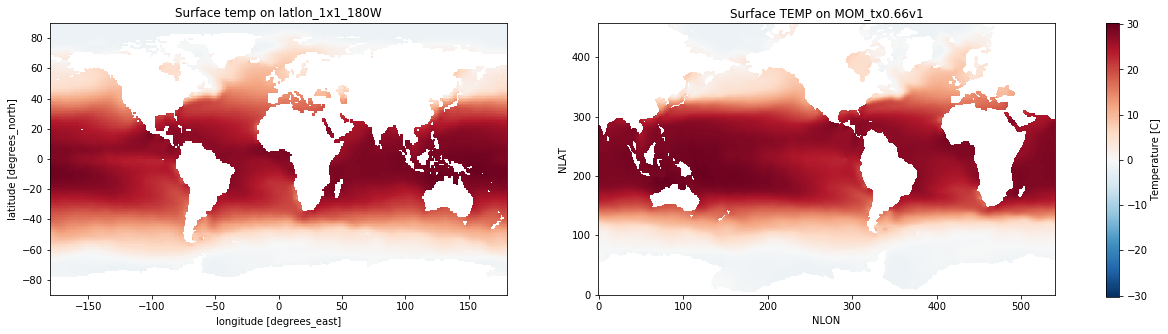


----

regridding SALT from latlon_1x1_180W to MOM_tx0.66v1



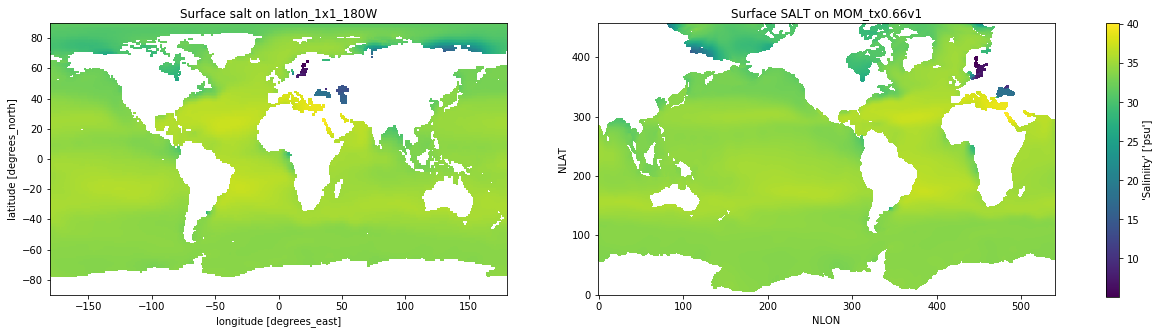


----

regridding NO3 from latlon_1x1_180W to MOM_tx0.66v1



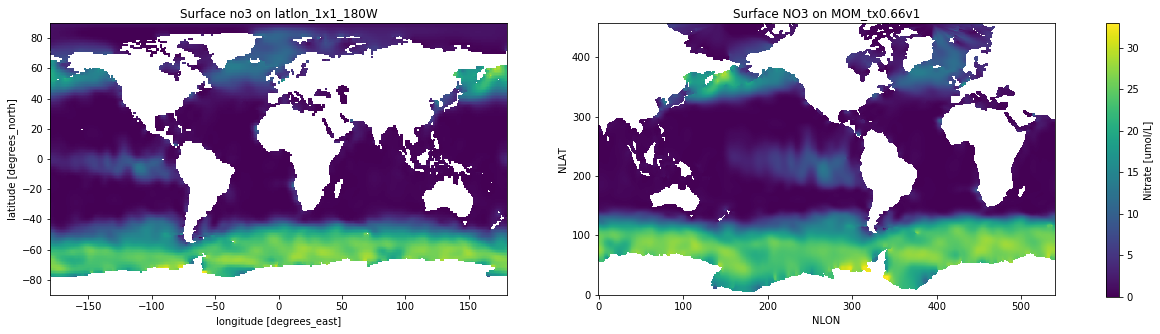


----

regridding PO4 from latlon_1x1_180W to MOM_tx0.66v1



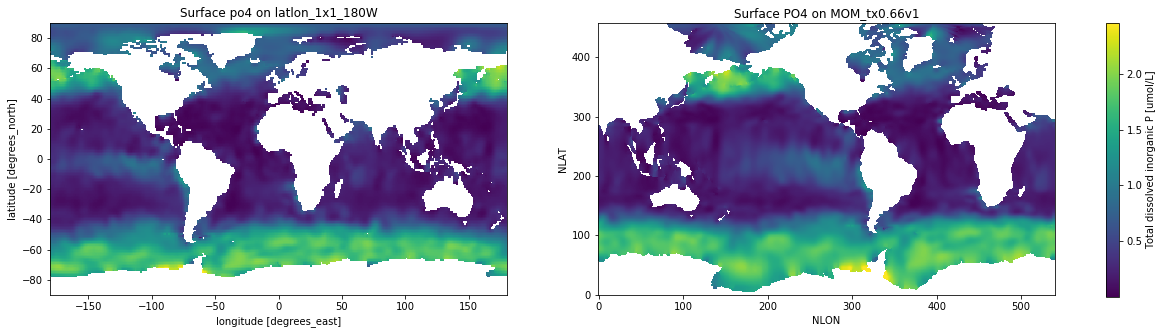


----

regridding SiO3 from latlon_1x1_180W to MOM_tx0.66v1



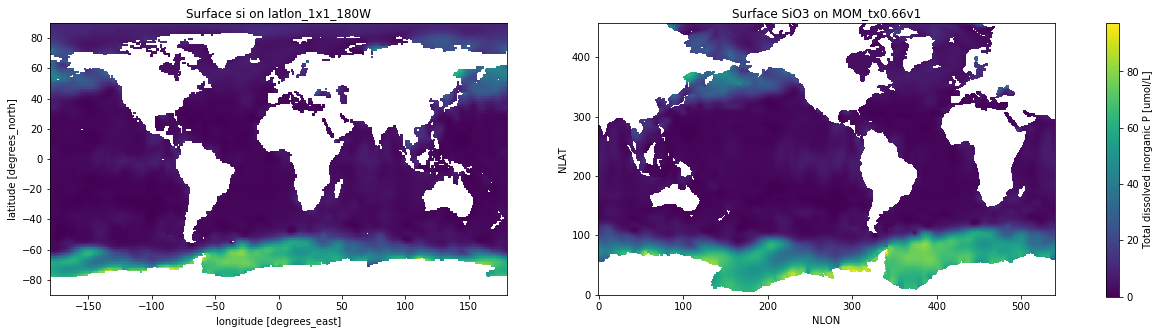


----

regridding O2 from latlon_1x1_180W to MOM_tx0.66v1



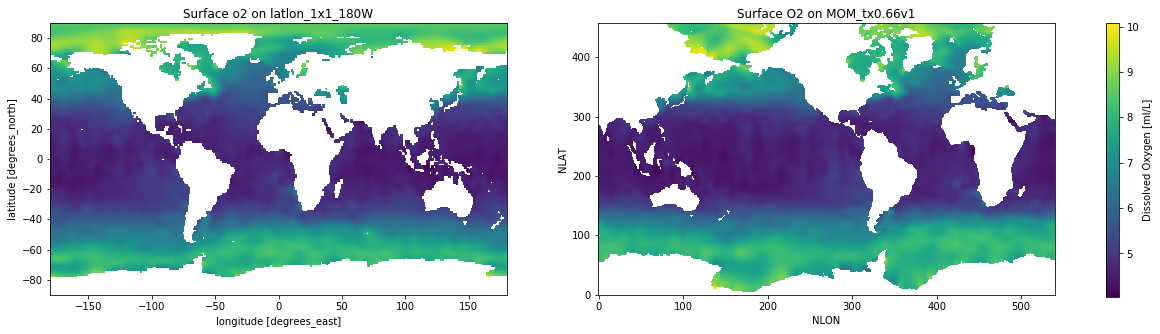


----

regridding DIC from latlon_1x1_20E to MOM_tx0.66v1



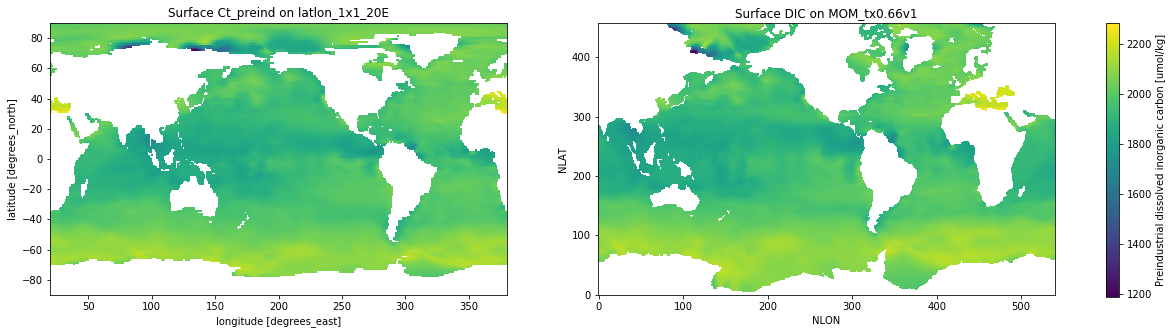


----

regridding ALK from latlon_1x1_20E to MOM_tx0.66v1



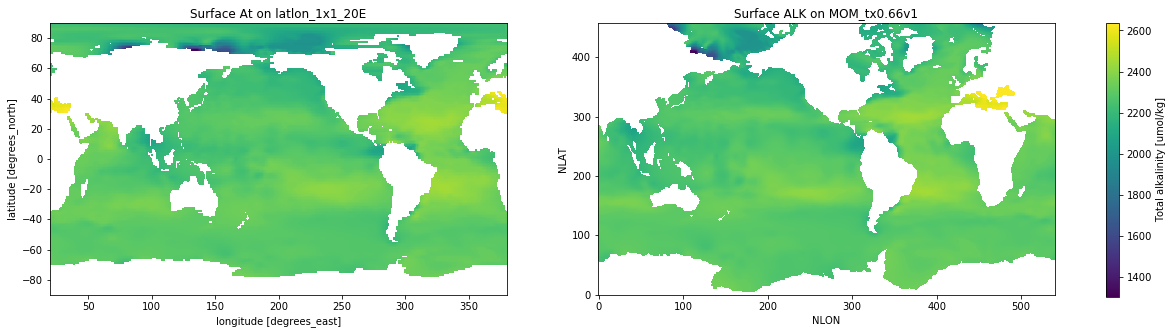


----

<xarray.Dataset>
Dimensions:          (DEPTH: 102, NLAT: 458, NLON: 540, grid_corners: 4, grid_rank: 2, grid_size: 247320)
Coordinates:
  * DEPTH            (DEPTH) float64 0.0 5.0 10.0 ... 5.3e+03 5.4e+03 5.5e+03
    LON              (NLAT, NLON) float64 -286.7 -286.0 -285.3 ... 72.98 73.0
    LAT              (NLAT, NLON) float64 -79.2 -79.2 -79.2 ... 50.11 49.99
Dimensions without coordinates: NLAT, NLON, grid_corners, grid_rank, grid_size
Data variables:
    grid_dims        (grid_rank) int32 540 458
    grid_center_lat  (grid_size) float64 -79.2 -79.2 -79.2 ... 50.27 50.11 49.99
    grid_center_lon  (grid_size) float64 -286.7 -286.0 -285.3 ... 72.98 73.0
    grid_imask       (grid_size) int32 ...
    grid_corner_lat  (grid_size, grid_corners) float64 ...
    grid_corner_lon  (grid_size, grid_corners) float64 ...
    grid_area        (grid_size) float64 ...
    TEMP             (DEPTH, NLAT, NLON) float64 nan nan nan nan ... nan nan nan
    SALT             (DEPTH, NLAT, NLO

In [8]:
%%time
%matplotlib inline
for tracername in omip_metadata:
    # decode_times=False because omip files have unsupported units
    #     "months since 0000-01-01 00:00:00"
    ds_omip = xr.open_dataset(dirin_omip+'/'+omip_metadata[tracername]['fname'], decode_times=False)

    varname_omip = omip_metadata[tracername]['varname']

    src_grid = omip_metadata[tracername]['grid']
    print(f'regridding {tracername} from {src_grid} to {dst_grid}\n')
    
    # Plot on src grid
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18.0, 5.0))
    plt.subplot(121)
    try:
        ds_omip[varname_omip].isel(time=0, depth=0).plot(add_colorbar=False)
    except:
        ds_omip[varname_omip].isel(depthz=0).plot(add_colorbar=False)
    plt.title(f"Surface {varname_omip} on {src_grid}")

    # perform lateral remapping
    regrid_operator = esmlab_regrid.regridder(
        name_grid_src=omip_metadata[tracername]['grid'], 
        name_grid_dst=dst_grid, method=interp_method, overwrite_existing=False)
    tracer_omip = ds_omip[varname_omip]
    if 'time' in tracer_omip.dims:
        tracer_omip = tracer_omip.isel(time=0, drop=True)
    tracer_lateral_regrid = regrid_operator(tracer_omip, renormalize=True)

    # generate vertical remapping weights
    depth_name_in = tracer_omip.dims[0]
    depth_bounds_name = ds_omip[depth_name_in].attrs['bounds']
    depth_remap_weights = gen_remap_weights_1d(
        ds_omip[depth_bounds_name], DEPTH_bounds,
        ds_omip[depth_name_in].attrs['units'], 'm')

    # perform vertical remapping
    nk_in = tracer_lateral_regrid.shape[0]
    tracer_lateral_regrid_flat = tracer_lateral_regrid.values.reshape((nk_in, nj*ni))
    tracer_full_regrid_flat = depth_remap_weights.dot(tracer_lateral_regrid_flat)
    tracer_full_regrid_values = tracer_full_regrid_flat.reshape((nk, nj, ni))
    tracer_full_regrid = xr.DataArray(tracer_full_regrid_values, dims=('DEPTH', 'NLAT', 'NLON'),
                                      coords={'DEPTH':ds_out.DEPTH}, attrs=tracer_omip.attrs)
    tracer_full_regrid = tracer_full_regrid.where(MASK)
    tracer_full_regrid.encoding['_FillValue'] = tracer_omip.encoding['_FillValue']
    
    # perform lateral fill (need in mom_tools!)
    tracer_full_regrid = pop_tools.lateral_fill(tracer_full_regrid, MASK, ltripole=ltripole)

    # perform vertical fill
    unfilled = tracer_full_regrid.isnull() & (MASK == 1.)                    
    if unfilled.any():
        for k in range(1, nk):
            tracer_full_regrid[k, :, :] = xr.where(unfilled[k, :, :],
                                                   tracer_full_regrid[k-1, :, :],
                                                   tracer_full_regrid[k, :, :])
        if (tracer_full_regrid.isnull() & (MASK == 1.)).any():
            warnings.warn(f'{tracername} still has missing values')

    ds_out[tracername] = tracer_full_regrid

    # Plot data
    plt.subplot(122)
    my_plot = ds_out[tracername].isel(DEPTH=0).plot(add_colorbar=False)
    plt.title(f'Surface {tracername} on {dst_grid}')
    cax = plt.axes((0.94, 0.12, 0.01, 0.76))
    cbar = fig.colorbar(my_plot, ax=axes.ravel().tolist(), cax=cax)
    cbar.set_label('{} [{}]'.format(ds_out[tracername].attrs['long_name'], ds_out[tracername].attrs['units']), rotation=90)
    plt.show()
    print('\n----\n')

print(ds_out)

In [9]:
rho_0 = 1.026
# change units of omip vars to model units
for tracername in omip_metadata:
    units = ds_out[tracername].attrs['units']
    if 'kg' in units:
        ds_out[tracername].values *= rho_0
        ds_out[tracername].attrs['units'] = units.replace('kg', 'L')
        ds_out[tracername].attrs['rho_0'] = rho_0
    if tracername == 'O2' and (units == 'ml/L' or units == 'milliliters_per_liter'):
        ds_out[tracername].values *= (1.0e3 / 22.3916)
        ds_out[tracername].attrs['units'] = 'umol/L'

need to include spC from b.e21.B1850.f09_g17.CMIP6-piControl.001 restart file
Updating dataset to account for possible overflows
Lateral remap
gen vertical remap weights
vertical remap
vertical fill


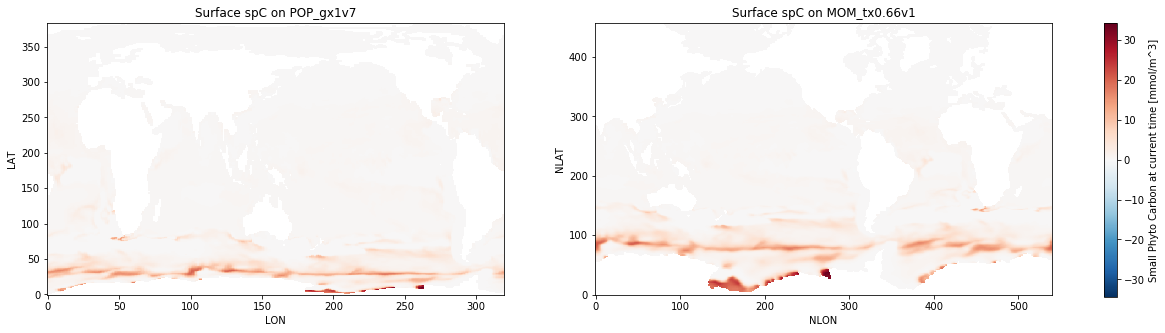


----

need to include spChl from b.e21.B1850.f09_g17.CMIP6-piControl.001 restart file
Updating dataset to account for possible overflows
Lateral remap
gen vertical remap weights
vertical remap
vertical fill


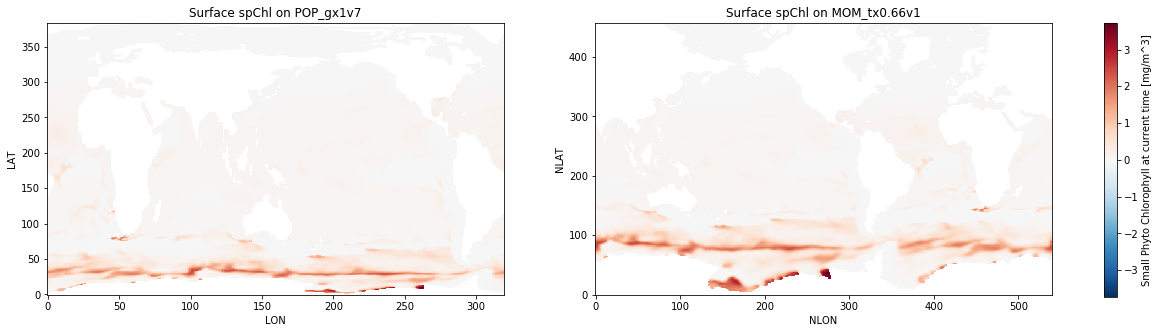


----

need to include spFe from b.e21.B1850.f09_g17.CMIP6-piControl.001 restart file
Updating dataset to account for possible overflows
Lateral remap
gen vertical remap weights
vertical remap
vertical fill


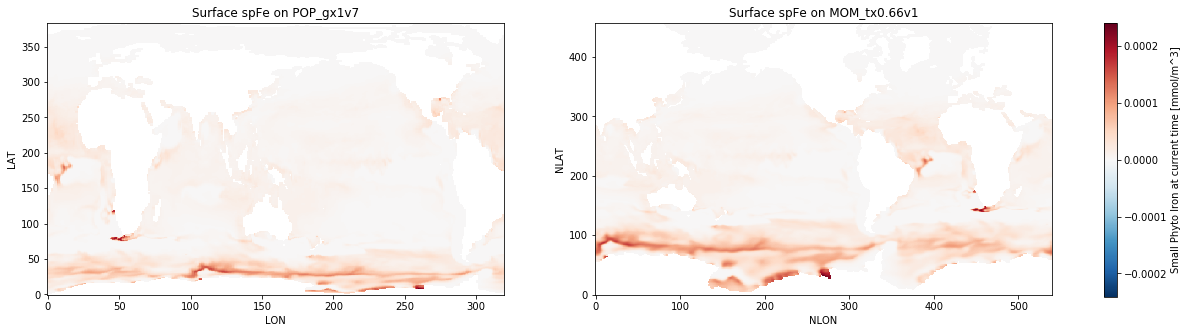


----

need to include spP from b.e21.B1850.f09_g17.CMIP6-piControl.001 restart file
Updating dataset to account for possible overflows
Lateral remap
gen vertical remap weights
vertical remap
vertical fill


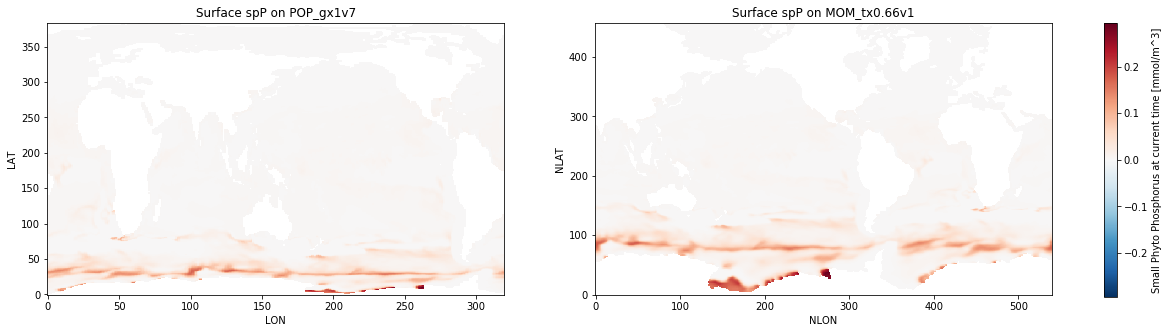


----

need to include spCaCO3 from b.e21.B1850.f09_g17.CMIP6-piControl.001 restart file
Updating dataset to account for possible overflows
Lateral remap
gen vertical remap weights
vertical remap
vertical fill


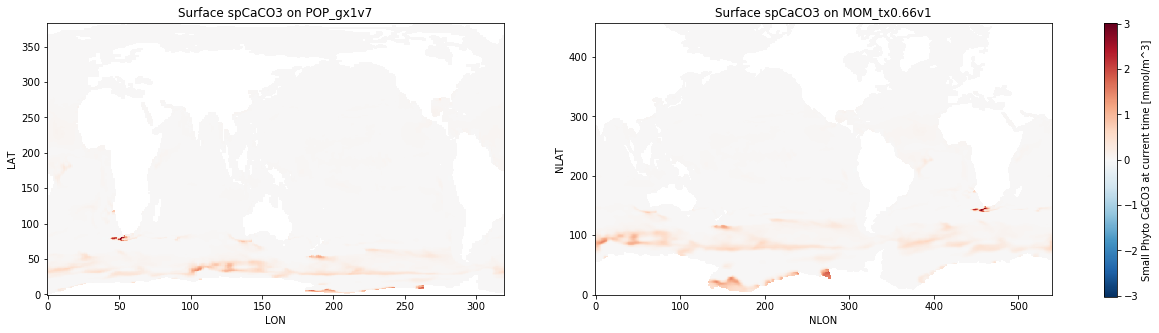


----

need to include diatC from b.e21.B1850.f09_g17.CMIP6-piControl.001 restart file
Updating dataset to account for possible overflows
Lateral remap
gen vertical remap weights
vertical remap
vertical fill


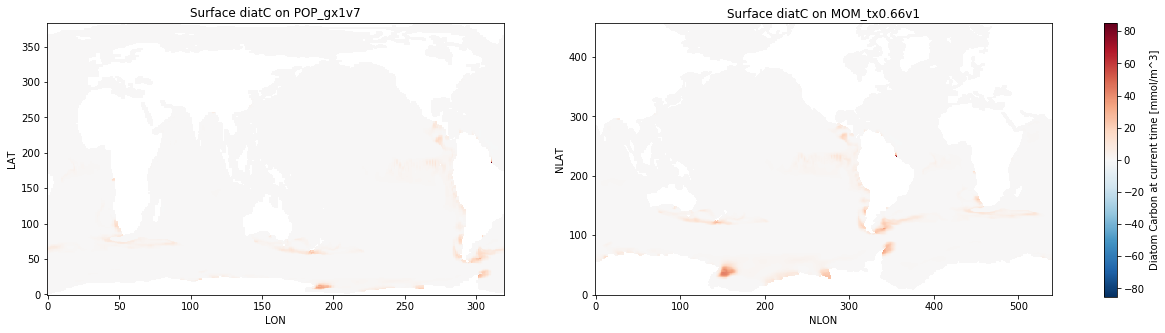


----

need to include diatChl from b.e21.B1850.f09_g17.CMIP6-piControl.001 restart file
Updating dataset to account for possible overflows
Lateral remap
gen vertical remap weights
vertical remap
vertical fill


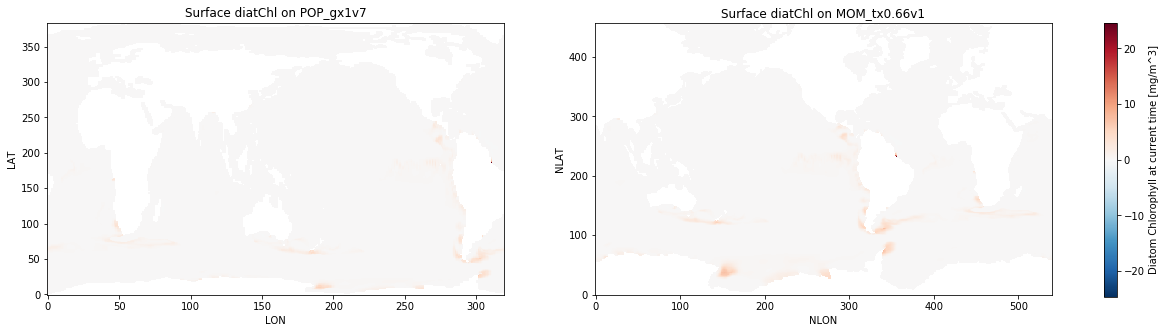


----

need to include diatFe from b.e21.B1850.f09_g17.CMIP6-piControl.001 restart file
Updating dataset to account for possible overflows
Lateral remap
gen vertical remap weights
vertical remap
vertical fill


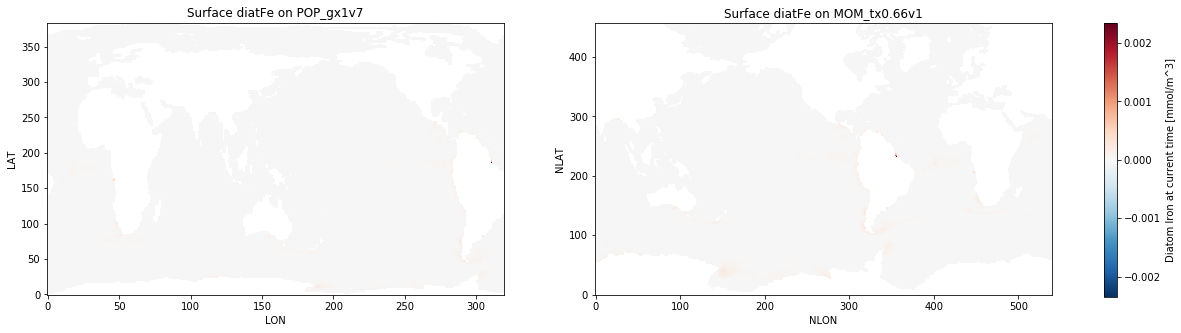


----

need to include diatP from b.e21.B1850.f09_g17.CMIP6-piControl.001 restart file
Updating dataset to account for possible overflows
Lateral remap
gen vertical remap weights
vertical remap
vertical fill


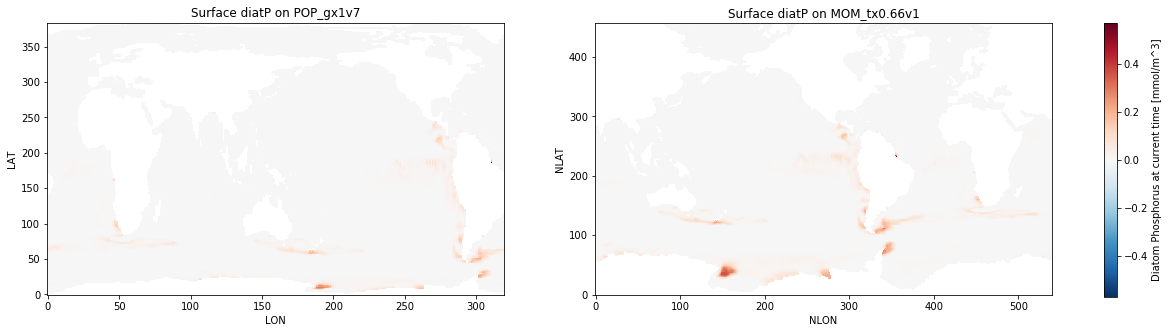


----

need to include diatSi from b.e21.B1850.f09_g17.CMIP6-piControl.001 restart file
Updating dataset to account for possible overflows
Lateral remap
gen vertical remap weights
vertical remap
vertical fill


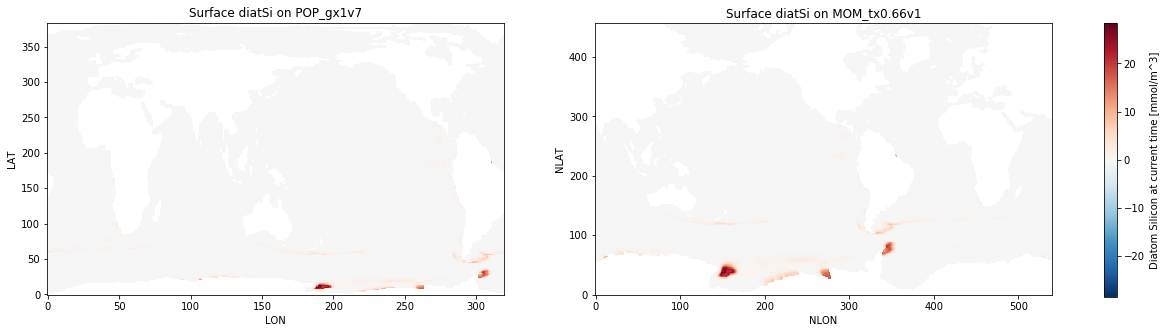


----

need to include diazC from b.e21.B1850.f09_g17.CMIP6-piControl.001 restart file
Updating dataset to account for possible overflows
Lateral remap
gen vertical remap weights
vertical remap
vertical fill


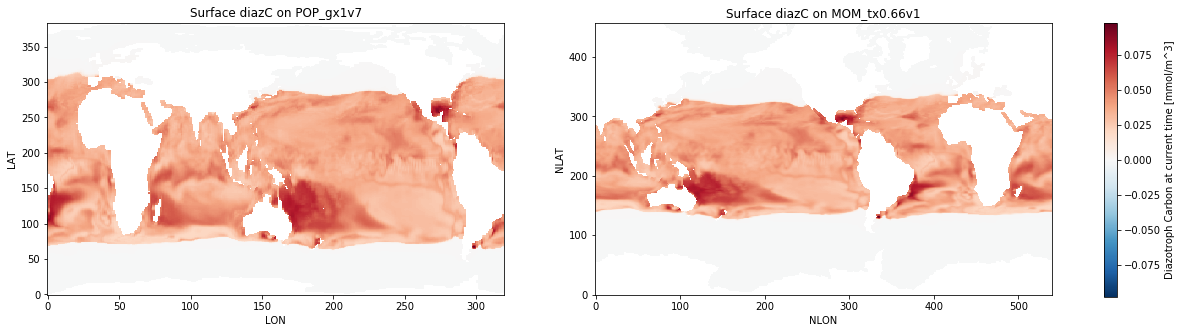


----

need to include diazChl from b.e21.B1850.f09_g17.CMIP6-piControl.001 restart file
Updating dataset to account for possible overflows
Lateral remap
gen vertical remap weights
vertical remap
vertical fill


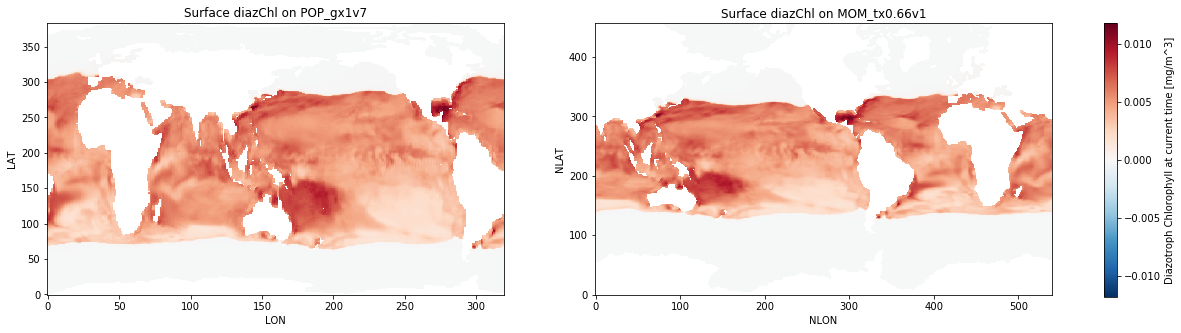


----

need to include diazFe from b.e21.B1850.f09_g17.CMIP6-piControl.001 restart file
Updating dataset to account for possible overflows
Lateral remap
gen vertical remap weights
vertical remap
vertical fill


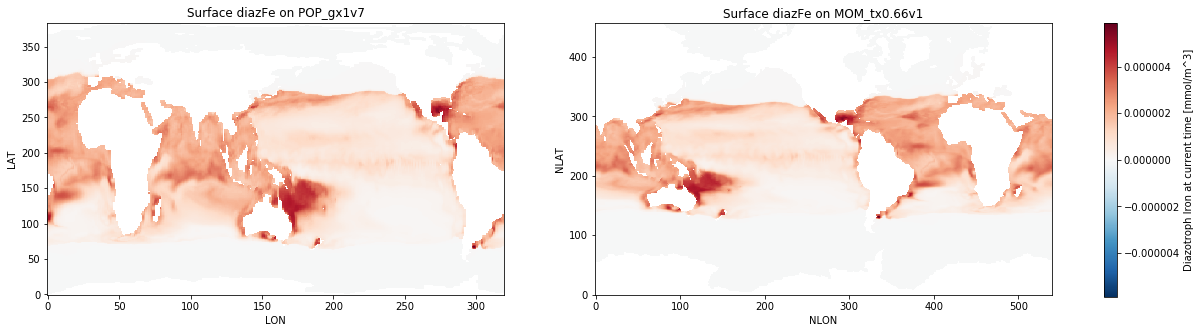


----

need to include diazP from b.e21.B1850.f09_g17.CMIP6-piControl.001 restart file
Updating dataset to account for possible overflows
Lateral remap
gen vertical remap weights
vertical remap
vertical fill


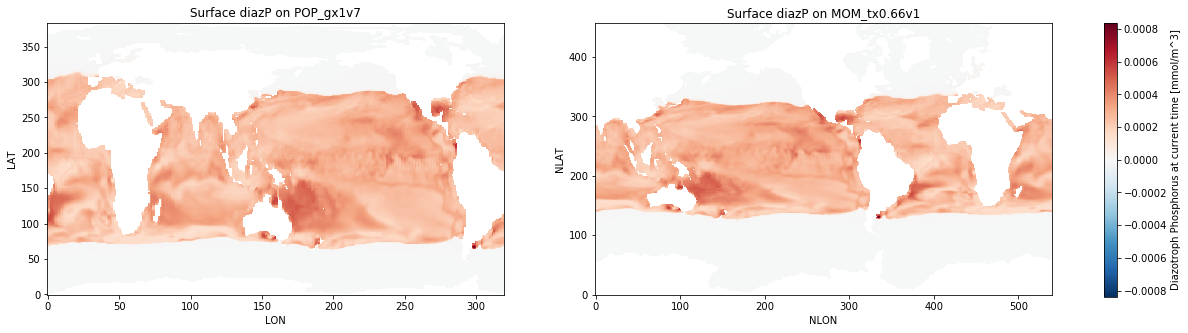


----

need to include zooC from b.e21.B1850.f09_g17.CMIP6-piControl.001 restart file
Updating dataset to account for possible overflows
Lateral remap
gen vertical remap weights
vertical remap
vertical fill


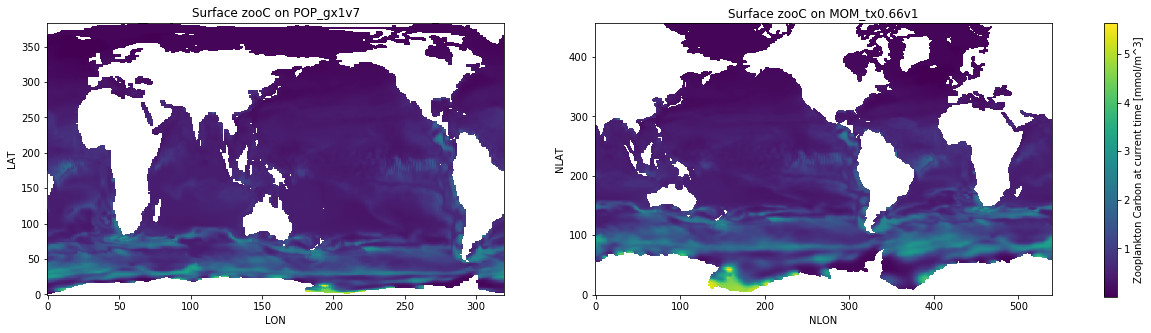


----

need to include DOC from b.e21.B1850.f09_g17.CMIP6-piControl.001 restart file
Updating dataset to account for possible overflows
Lateral remap
gen vertical remap weights
vertical remap
vertical fill


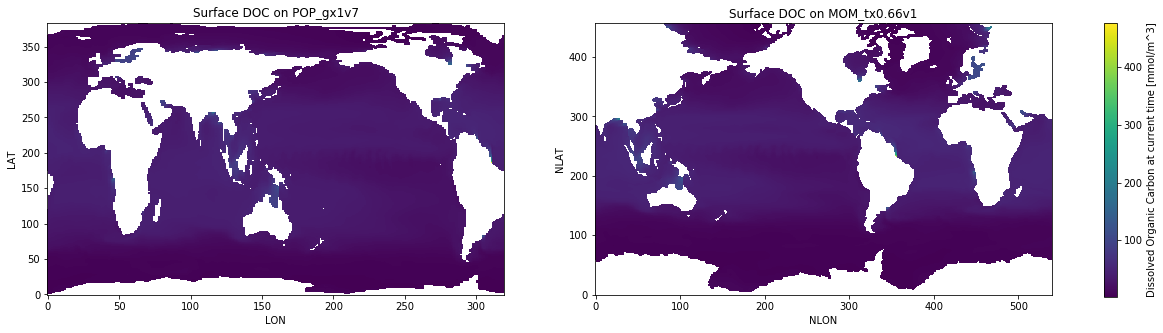


----

need to include DOCr from b.e21.B1850.f09_g17.CMIP6-piControl.001 restart file
Updating dataset to account for possible overflows
Lateral remap
gen vertical remap weights
vertical remap
vertical fill


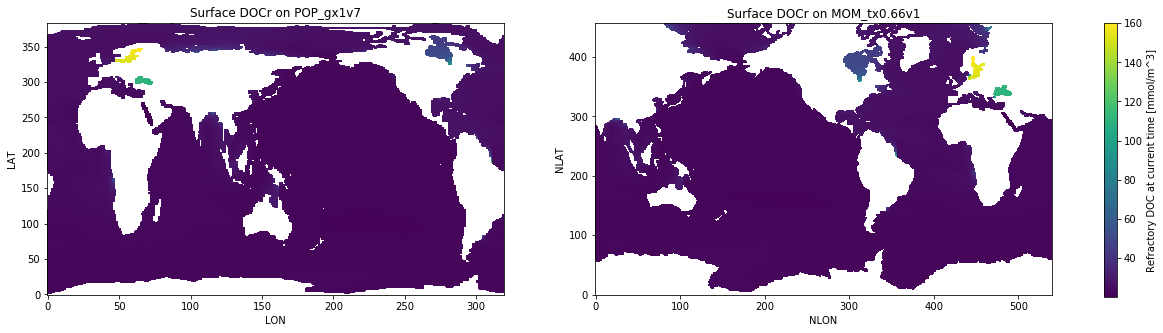


----

need to include DON from b.e21.B1850.f09_g17.CMIP6-piControl.001 restart file
Updating dataset to account for possible overflows
Lateral remap
gen vertical remap weights
vertical remap
vertical fill


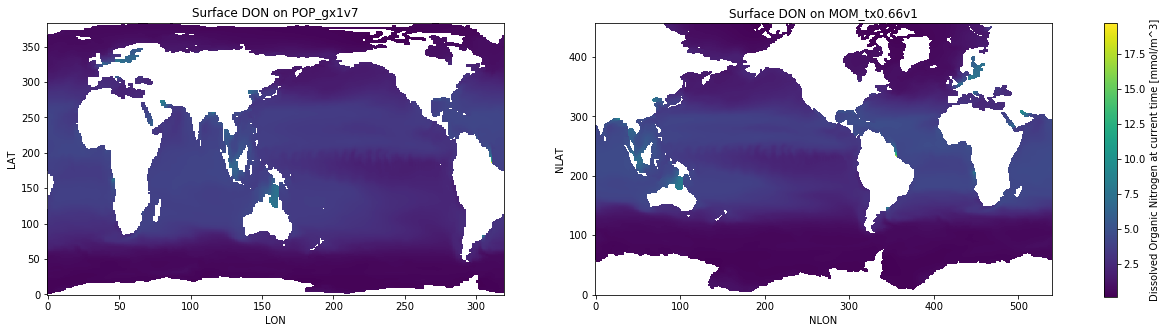


----

need to include DONr from b.e21.B1850.f09_g17.CMIP6-piControl.001 restart file
Updating dataset to account for possible overflows
Lateral remap
gen vertical remap weights
vertical remap
vertical fill


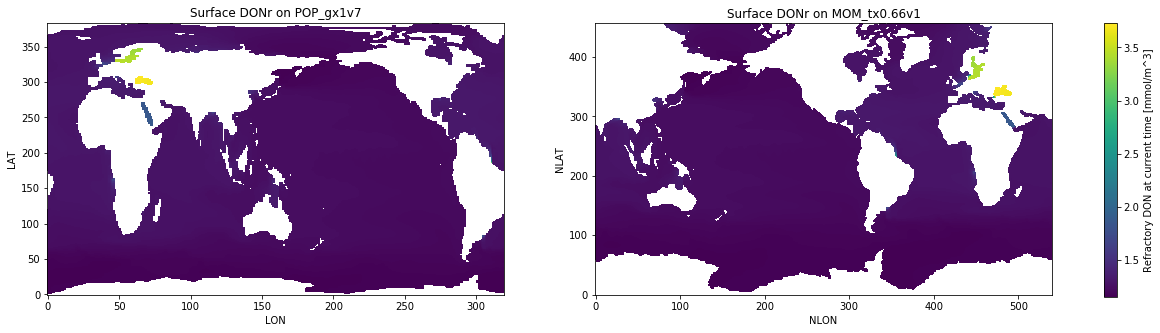


----

need to include DOP from b.e21.B1850.f09_g17.CMIP6-piControl.001 restart file
Updating dataset to account for possible overflows
Lateral remap
gen vertical remap weights
vertical remap
vertical fill


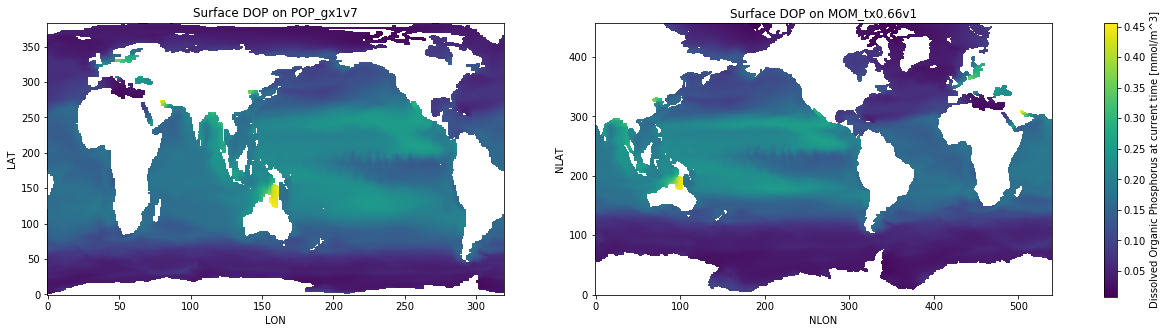


----

need to include DOPr from b.e21.B1850.f09_g17.CMIP6-piControl.001 restart file
Updating dataset to account for possible overflows
Lateral remap
gen vertical remap weights
vertical remap
vertical fill


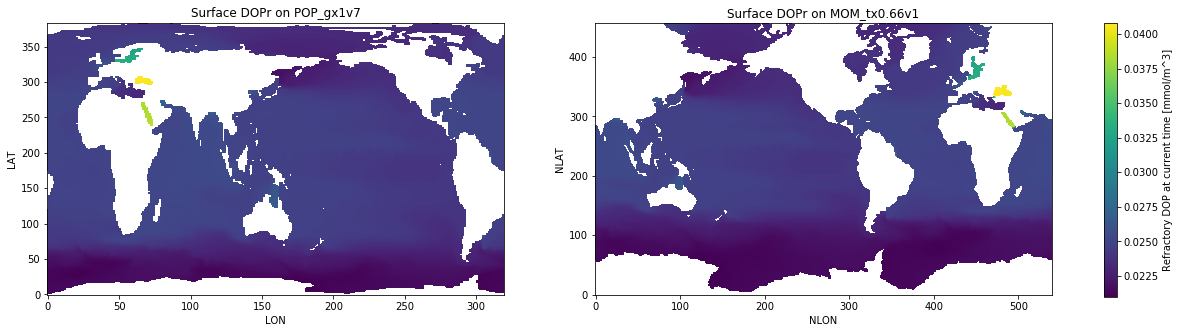


----

need to include NH4 from b.e21.B1850.f09_g17.CMIP6-piControl.001 restart file
Updating dataset to account for possible overflows
Lateral remap
gen vertical remap weights
vertical remap
vertical fill


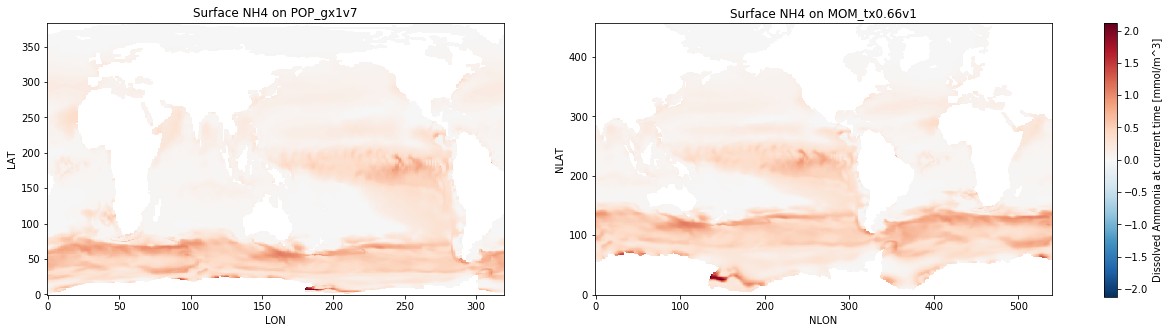


----

need to include Fe from b.e21.B1850.f09_g17.CMIP6-piControl.001 restart file
Updating dataset to account for possible overflows
Lateral remap
gen vertical remap weights
vertical remap
vertical fill


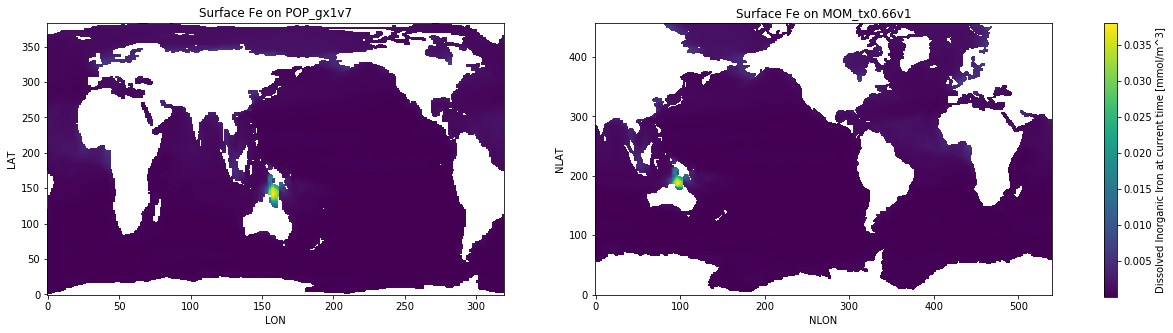


----

need to include Lig from b.e21.B1850.f09_g17.CMIP6-piControl.001 restart file
Updating dataset to account for possible overflows
Lateral remap
gen vertical remap weights
vertical remap
vertical fill


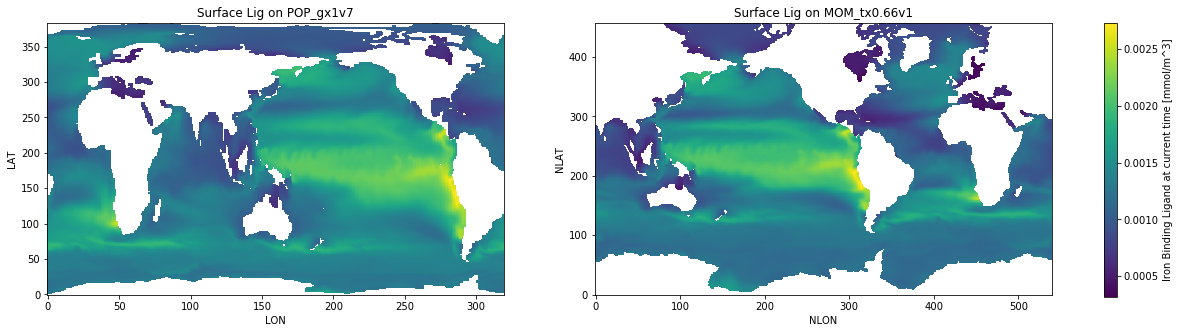


----

<xarray.Dataset>
Dimensions:          (DEPTH: 102, NLAT: 458, NLON: 540, grid_corners: 4, grid_rank: 2, grid_size: 247320)
Coordinates:
  * DEPTH            (DEPTH) float64 0.0 5.0 10.0 ... 5.3e+03 5.4e+03 5.5e+03
    LON              (NLAT, NLON) float64 -286.7 -286.0 -285.3 ... 72.98 73.0
    LAT              (NLAT, NLON) float64 -79.2 -79.2 -79.2 ... 50.11 49.99
Dimensions without coordinates: NLAT, NLON, grid_corners, grid_rank, grid_size
Data variables:
    grid_dims        (grid_rank) int32 540 458
    grid_center_lat  (grid_size) float64 -79.2 -79.2 -79.2 ... 50.27 50.11 49.99
    grid_center_lon  (grid_size) float64 -286.7 -286.0 -285.3 ... 72.98 73.0
    grid_imask       (grid_size) int32 ...
    grid_corner_lat  (grid_size, grid_corners) float64 ...
    grid_corner_lon  (grid_size, grid_corners) float64 ...
    grid_area        (grid_size) float64 ...
    TEMP             (DEPTH, NLAT, NLON) float64 nan nan nan nan ... nan nan nan
    SALT             (DEPTH, NLAT, NLO

In [10]:
%%time
# map tracers not yet in ds_out from refcase restart file to ds_out
fillvalue = -1.0e34 # value to replace land values with

src_grid = 'POP_gx1v7'
ds_refcase = xr.open_dataset(fname_refcase).rename({'k':'DEPTH', 'j':'LAT', 'i':'LON'})

# Set up POP vertical grid from POP's initial condition file
ds_vert = xr.open_dataset('/glade/p/cesmdata/cseg/inputdata/ocn/pop/gx1v7/ic/ecosys_jan_IC_omip_POP_gx1v7_c190615.nc')
ds_src_grid = pop_tools.get_grid(src_grid)
ocnmask = (ds_src_grid["REGION_MASK"].values != 0)

# Will need vertical interpolation as well as horizontal!
for tracername in tracernames:
    if tracername not in ds_out.data_vars:
        print(f'need to include {tracername} from {refcase} restart file')
        tracer = ds_refcase[tracername+'_CUR']
        tracer.encoding['_FillValue'] = fillvalue
        nk_in = tracer.shape[0]

        # Set floor values that are 0.0 to value 1 layer shallower and mask out land.
        # This is to fill in values where KMT was popped up by overflow parameterization.
        # This is needed to enable using ds_out in runs where overflows are disabled.
        for k in range(1, nk_in):
            tracer[k, :, :].values = xr.where((tracer.values[k, :, :] == 0.0) & (k+1 == ds_vert.KMT.values),
                                       tracer.values[k-1, :, :], tracer.values[k, :, :])
        tracer.values = np.where(ocnmask, tracer.values, np.nan)

        # Plot on src grid
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18.0, 5.0))
        plt.subplot(121)
        tracer.isel(DEPTH=0).plot(add_colorbar=False)
        plt.title(f"Surface {tracername} on {src_grid}")

        # perform lateral remapping
        regrid_operator = esmlab_regrid.regridder(
            name_grid_src=src_grid, name_grid_dst=dst_grid,
            method=interp_method, overwrite_existing=False)
        tracer_lateral_regrid = regrid_operator(tracer, renormalize=True)

        # generate vertical remapping weights
        depth_name_in = tracer.dims[0]
        depth_remap_weights = gen_remap_weights_1d(
            ds_vert['z_t_bounds'], DEPTH_bounds,
            ds_vert['z_t'].attrs['units'], 'm')

        # perform vertical remapping
        tracer_lateral_regrid_flat = tracer_lateral_regrid.values.reshape((nk_in, nj*ni))
        tracer_full_regrid_flat = depth_remap_weights.dot(tracer_lateral_regrid_flat)
        tracer_full_regrid_values = tracer_full_regrid_flat.reshape((nk, nj, ni))
        tracer_full_regrid = xr.DataArray(tracer_full_regrid_values, dims=('DEPTH', 'NLAT', 'NLON'),
                                          coords={'DEPTH':ds_out.DEPTH}, attrs=tracer.attrs)
        tracer_full_regrid = tracer_full_regrid.where(MASK)
        tracer_full_regrid.encoding['_FillValue'] = fillvalue

        # perform lateral fill (need in mom_tools!)
        tracer_full_regrid = pop_tools.lateral_fill(tracer_full_regrid, MASK, ltripole=ltripole)#, use_sor=True)

        # perform vertical fill
        unfilled = tracer_full_regrid.isnull() & (MASK == 1.)                    
        if unfilled.any():
            for k in range(1, nk):
                tracer_full_regrid[k, :, :] = xr.where(unfilled[k, :, :],
                                                       tracer_full_regrid[k-1, :, :],
                                                       tracer_full_regrid[k, :, :])
            if (tracer_full_regrid.isnull() & (MASK == 1.)).any():
                warnings.warn(f'{tracername} still has missing values')

        ds_out[tracername] = tracer_full_regrid
        plt.subplot(122)
        my_plot = ds_out[tracername].isel(DEPTH=0).plot(add_colorbar=False)
        plt.title(f'Surface {tracername} on {dst_grid}')
        cax = plt.axes((0.94, 0.12, 0.01, 0.76))
        cbar = fig.colorbar(my_plot, ax=axes.ravel().tolist(), cax=cax)
        cbar.set_label('{} [{}]'.format(tracer.attrs['long_name'],
                                        tracer.attrs['units']),
                                        rotation=90)
        plt.show()
        print('\n----\n')
        plt.show()

print(ds_out)

In [11]:
# set derived quantities

ds_out['DIC_ALT_CO2'] = ds_out['DIC']
ds_out['ALK_ALT_CO2'] = ds_out['ALK']
# DOCtot = ds_out['DOC'].copy()
# DOCtot.values = ds_out['DOC'].values + ds_out['DOCr'].values
# DOCtot.attrs['long_name'] = 'DOC + DOCr'
# ds_out['DOCtot'] = DOCtot

if 'grid_dims' in ds_out.variables:
    ds_out = ds_out.drop(['grid_dims', 'grid_center_lat', 'grid_center_lon', 'grid_corner_lat', 'grid_corner_lon', 'grid_imask', 'grid_area'])
ds_out

<xarray.Dataset>
Dimensions:      (DEPTH: 102, NLAT: 458, NLON: 540)
Coordinates:
  * DEPTH        (DEPTH) float64 0.0 5.0 10.0 15.0 ... 5.3e+03 5.4e+03 5.5e+03
    LON          (NLAT, NLON) float64 -286.7 -286.0 -285.3 ... 72.97 72.98 73.0
    LAT          (NLAT, NLON) float64 -79.2 -79.2 -79.2 ... 50.27 50.11 49.99
Dimensions without coordinates: NLAT, NLON
Data variables:
    TEMP         (DEPTH, NLAT, NLON) float64 nan nan nan nan ... nan nan nan nan
    SALT         (DEPTH, NLAT, NLON) float64 nan nan nan nan ... nan nan nan nan
    NO3          (DEPTH, NLAT, NLON) float64 nan nan nan nan ... nan nan nan nan
    PO4          (DEPTH, NLAT, NLON) float64 nan nan nan nan ... nan nan nan nan
    SiO3         (DEPTH, NLAT, NLON) float64 nan nan nan nan ... nan nan nan nan
    O2           (DEPTH, NLAT, NLON) float64 nan nan nan nan ... nan nan nan nan
    DIC          (DEPTH, NLAT, NLON) float64 nan nan nan nan ... nan nan nan nan
    ALK          (DEPTH, NLAT, NLON) float64 nan nan nan nan ... nan nan nan nan
    spC          (DEPTH, NLAT, NLON) float64 nan nan nan nan ... nan nan nan nan
    spChl        (DEPTH, NLAT, NLON) float64 nan nan nan nan ... nan nan nan nan
    spFe         (DEPTH, NLAT, NLON) float64 nan nan nan nan ... nan nan nan nan
    spP          (DEPTH, NLAT, NLON) float64 nan nan nan nan ... nan nan nan nan
    spCaCO3      (DEPTH, NLAT, NLON) float64 nan nan nan nan ... nan nan nan nan
    diatC        (DEPTH, NLAT, NLON) float64 nan nan nan nan ... nan nan nan nan
    diatChl      (DEPTH, NLAT, NLON) float64 nan nan nan nan ... nan nan nan nan
    diatFe       (DEPTH, NLAT, NLON) float64 nan nan nan nan ... nan nan nan nan
    diatP        (DEPTH, NLAT, NLON) float64 nan nan nan nan ... nan nan nan nan
    diatSi       (DEPTH, NLAT, NLON) float64 nan nan nan nan ... nan nan nan nan
    diazC        (DEPTH, NLAT, NLON) float64 nan nan nan nan ... nan nan nan nan
    diazChl      (DEPTH, NLAT, NLON) float64 nan nan nan nan ... nan nan nan nan
    diazFe       (DEPTH, NLAT, NLON) float64 nan nan nan nan ... nan nan nan nan
    diazP        (DEPTH, NLAT, NLON) float64 nan nan nan nan ... nan nan nan nan
    zooC         (DEPTH, NLAT, NLON) float64 nan nan nan nan ... nan nan nan nan
    DOC          (DEPTH, NLAT, NLON) float64 nan nan nan nan ... nan nan nan nan
    DOCr         (DEPTH, NLAT, NLON) float64 nan nan nan nan ... nan nan nan nan
    DON          (DEPTH, NLAT, NLON) float64 nan nan nan nan ... nan nan nan nan
    DONr         (DEPTH, NLAT, NLON) float64 nan nan nan nan ... nan nan nan nan
    DOP          (DEPTH, NLAT, NLON) float64 nan nan nan nan ... nan nan nan nan
    DOPr         (DEPTH, NLAT, NLON) float64 nan nan nan nan ... nan nan nan nan
    NH4          (DEPTH, NLAT, NLON) float64 nan nan nan nan ... nan nan nan nan
    Fe           (DEPTH, NLAT, NLON) float64 nan nan nan nan ... nan nan nan nan
    Lig          (DEPTH, NLAT, NLON) float64 nan nan nan nan ... nan nan nan nan
    DIC_ALT_CO2  (DEPTH, NLAT, NLON) float64 nan nan nan nan ... nan nan nan nan
    ALK_ALT_CO2  (DEPTH, NLAT, NLON) float64 nan nan nan nan ... nan nan nan nan
Attributes:
    date_created:  Thu Mar 14 14:15:56 MDT 2019
    Createdby:     ESMF_regridding.ncl
    Conventions:   SCRIP
    title:         tx0.66v1 Grid

In [12]:
# write generated file

datestamp = datetime.now(timezone.utc).strftime("%Y-%m-%d")
ds_out.attrs['history'] = f'created by {id_string} on {datestamp}'
omip_file_list = [dirin_omip+'/'+omip_metadata[varname]['fname'] for varname in omip_metadata]
ds_out.attrs['input_file_list'] = ' '.join(omip_file_list + [fname_refcase])
util.ds_clean(ds_out).to_netcdf(fname_out)